<a href="https://colab.research.google.com/github/TatKhachatryan/Data_Analyst_tasks/blob/main/Data_Analyst_tasks(Tatevik_Khachatryan).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import pandas as pd
import numpy as np
import pandas.util.testing as tm

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None


# **Task 1: Data Cleaning**

In [2]:
df = pd.read_csv('/content/drive/MyDrive/loans.csv')
# df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SEX                       203 non-null    object 
 1   OPENDATE                  203 non-null    object 
 2   CURRENCY                  198 non-null    float64
 3   RATE                      203 non-null    object 
 4   DISBURSEMENT              200 non-null    float64
 5   OUTSTANDING               201 non-null    float64
 6   OVERDUEDAYS               203 non-null    int64  
 7   rcvLoansCount             203 non-null    int64  
 8   banks_rcvloans            203 non-null    object 
 9   uco_rcvloans              203 non-null    int64  
 10  nonOverdue_loans_prop     202 non-null    object 
 11  liabs_and_principal_prop  203 non-null    object 
 12  CurrentLoansCount         203 non-null    int64  
 13  maxLoan                   203 non-null    int64  
 14  currentPMT

Քանի որ 'nonOverdue_loans_prop' սյունակի արժեքները թվային են, ես որոշեցի 'object' type-ից այն դարձնել 'float64'. Սակայն ստացա ValueError. Պատճառը այս արժեքն էր - '0?2a' 16 ինդեքսով (նայիր ներքևում).

In [3]:
df.loc[df['nonOverdue_loans_prop']=='0?2a']

,SEX,OPENDATE,CURRENCY,RATE,DISBURSEMENT,OUTSTANDING,OVERDUEDAYS,rcvLoansCount,banks_rcvloans,uco_rcvloans,nonOverdue_loans_prop,liabs_and_principal_prop,CurrentLoansCount,maxLoan,currentPMT,total_repaid_amount,totOverdue,totLiab,SwitchClassQ
16,F,20/11/19,0.0,19.9,393000.0,393000.0,0,14,6,8,0?2a,0.558674686,8,1485000,283972.0,4145810.0,0,5248190.0,0


Ես փոխարինեցի '0?2a' արժեքը NaN արժեքով, այնուհետև կատարեցի 'object' - 'float64' փոփոխությունը։

In [4]:
df['nonOverdue_loans_prop'] = df['nonOverdue_loans_prop'].replace({'0?2a': np.nan})
df['nonOverdue_loans_prop'] = df['nonOverdue_loans_prop'].astype('float64')

In [5]:
# df.isna().sum()

#### Եզրակացություն՝
Տվյալներում կան 15 բացակա արժեքներ՝

● CURRENCY - 5 <br>
● DISBURSEMENT - 3 <br>
● OUTSTANDING - 2 <br>
● nonOverdue_loans_prop - 1 <br>
● currentPMT - 1 <br>
● total_repaid_amount - 2 <br>
● totLiab - 1

In [6]:
# custom ֆունկցիա, որը բացակա արժեքները փոխարինում է տվյալ սյունակի միջին արժեքով
def fill_missing_values(df):
    df['DISBURSEMENT'].fillna(int(df['DISBURSEMENT'].mean()), inplace=True)
    df['OUTSTANDING'].fillna(int(df['OUTSTANDING'].mean()), inplace=True)
    df['nonOverdue_loans_prop'].fillna(int(df['nonOverdue_loans_prop'].mean()), inplace=True)
    df['currentPMT'].fillna(int(df['currentPMT'].mean()), inplace=True)
    df['total_repaid_amount'].fillna(int(df['total_repaid_amount'].mean()), inplace=True)
    df['totLiab'].fillna(int(df['totLiab'].mean()), inplace=True)
    
    print('Done!')

In [7]:
fill_missing_values(df)

Done!


Որոշ սյունակներ ոչ ճշգրիտ/անհամապատասխան արժեքներ ունեն, հնարավորինս անվտանգ կերպով ուղղել եմ նմանատիպ արժեքները, առանց ինֆորմացիա կորցնելու՝

In [8]:
df['RATE'] = df['RATE'].replace({'24c': '24',
                                '1999': '19.9'})

df['DISBURSEMENT'] = df['DISBURSEMENT'].replace({-783000.: 783000., 
                                                 -500000.: 500000})

df['rcvLoansCount'] = df['rcvLoansCount'].replace({-12: 12,
                                                   106: 10,
                                                  1999: 19})

df['banks_rcvloans'] = df['banks_rcvloans'].replace({'1999': '19',
                                                    '14b': '14'})

df['uco_rcvloans'] = df['uco_rcvloans'].replace({1999: 19,
                                                -3: 3})

df['maxLoan'] = df['maxLoan'].replace({-1000000: 1000000,
                                       -3000000: 3000000,
                                       -1603860: 1603860})

df['liabs_and_principal_prop'] = df['liabs_and_principal_prop'].replace({'0.187428195b': '0.187428195'})

In [9]:
# 'CURRENCY' սյունակը պետք է պարունակի 0 և 1 արժեքները (AMD և USD). Քանի որ, չգիտեմ թե NaN արժեքի տակ ինչ փոխարժեք է, ստիպված եմ դրանք հեռացնել։
df['CURRENCY'].unique()

array([ 0., nan,  1.])

In [10]:
#df.loc[(df['CURRENCY'] !=1) & (df['CURRENCY'] !=0)]

df.drop([2, 14, 76, 89, 101], inplace=True)

df['CURRENCY'] = df['CURRENCY'].astype('int')

In [11]:
# ևս մի քանի փոփոխություն տվյալների ճշգրիտ տեսակների մեջ
df['OPENDATE'] = pd.to_datetime(df['OPENDATE'])
df['RATE'] = df['RATE'].astype('float')
df['banks_rcvloans'] = df['banks_rcvloans'].astype('int')
df['liabs_and_principal_prop'] = df['liabs_and_principal_prop'].astype('float')

### Correlation փոփոխականների միջև

In [12]:
corr = df.corr()

fig = px.imshow(corr, text_auto='.2f', width=1000, height=800)
fig.show()

#### **0.7-ից բարձր correlation ունեցող փոփոխականներն են**՝

1. maxLoan/totLiab - 0.91,
2. OUTSTANDING/DISBURSEMENT - 0.9,
3. banks_rcvloans/rcvLoansCount - 0.86
4. total_repaid_amount/maxLoan - 0.83,
5. total_repaid_amount/totLiab - 0.82,
6. currentPMT/totLiab - 0.82,
7. currentPMT/total_repaid_amount - 0.79,
8. currentPMT/maxLoan - 0.78

Հաջորդիվ կջնջեմ այն փոփոխականները, որոնք անհրաժեշտ չեն Exploratory Data Analysis-ի համար։

In [13]:
df.drop(['nonOverdue_loans_prop', 'liabs_and_principal_prop', 'totOverdue', 'SwitchClassQ'], axis=1, inplace=True)

# **Task 2: Exploratory Data Analysis**

In [14]:
# PAR1 սյունակում այն անձինք, ովքեր ունեն 1 օրից ավել overduedays՝ կստանան 1 արժեքը, ովքեր չունեն overduedays՝ կստանան 0
conditions = [df['OVERDUEDAYS'] > 1, df['OVERDUEDAYS'] <= 1]
outputs = [1, 0]

new_col = np.select(conditions, outputs, 'Other')

df['PAR1'] = new_col

In [15]:
df['PAR1'] = df['PAR1'].astype('int')
df['PAR1'].value_counts()

0    122
1     76
Name: PAR1, dtype: int64

Ընդհանուր 198 թվով տվյալների մեջ 76-ը ունեն ժամկետանց վարկեր, իսկ 122-ը՝ վճարել են ժամանակին։

In [16]:
# SEX սյունակը միակ ոչ թվային արժեքով կատեգորիալ փոփոխականն էր և ես ընտրեցի այն իմ ֆունկցիայի համար

# F_or_M() ֆունկցիան վերցնում է F/M/Both արժեքները որպես արգումենտ և վերադարձնում է աղյուսակ և ցույց է տալիս 
# ընտրված արժեքին համապատասխանող կատեգորիայի նկարագրությունը

def F_or_M(string):
#     string = str(input('Գրեք F կամ M կամ Both: '))
    
    custom_table = pd.DataFrame({'PAR1': [0, 0, 1, 1],
                            'SEX': ['F', 'M', 'F', 'M'],
                            'Num. of observations': [60, 58, 48, 32],
                            'Perc. (%)': [30, 29, 24, 16]})
    
    if string == 'F':
        return custom_table.loc[custom_table['SEX']=='F']
    elif string == 'M':
        return custom_table.loc[custom_table['SEX']=='M']
    elif string == 'Both':
        return custom_table
    else:
        return 'Գրեք ՄԻԱՅՆ F կամ M կամ Both․'

In [17]:
print(F_or_M('Both'))

   PAR1 SEX  Num. of observations  Perc. (%)
0     0   F                    60         30
1     0   M                    58         29
2     1   F                    48         24
3     1   M                    32         16


In [18]:
custom_table = pd.DataFrame({'PAR1': [0, 0, 1, 1],
                            'Mean': ['F', 'M', 'F', 'M'],
                            'Std': [60, 58, 48, 32]})

def mean_and_std(user='RATE'): # RATE is the default value. Pass anhy numerical value as an argument.

    mean = df.groupby('PAR1')[f'{user}'].mean()
    std = df.groupby('PAR1')[f'{user}'].std()

    mean_df = pd.DataFrame(list(mean.items()), columns = ['PAR1', 'Mean of '+ f'{user}'])
    std_df = pd.DataFrame(list(std.items()), columns = ['PAR1', ' Std of '+ f'{user}'])
    
    mean_and_std = pd.concat([mean_df, std_df], axis=1)
    
    return mean_and_std

In [19]:
print(mean_and_std('banks_rcvloans'))

   PAR1  Mean of banks_rcvloans  PAR1   Std of banks_rcvloans
0     0                8.778689     0                9.040325
1     1                7.289474     1                6.349416


**Show the mean and variability of total liabilities by PAR groups.**

In [20]:
df.groupby('PAR1')['totLiab'].mean().sort_values(ascending=False)

PAR1
0    3.397480e+06
1    3.002509e+06
Name: totLiab, dtype: float64

**Show the number of observations grouped by gender and PAR1.**

In [21]:
df[['PAR1', 'SEX']].value_counts()

PAR1  SEX
0     F      63
      M      59
1     M      47
      F      29
dtype: int64

**Then show the number of observations grouped by another categorical variable and PAR1.**

In [22]:
df[['PAR1', 'CURRENCY']].value_counts()

PAR1  CURRENCY
0     0           85
1     1           41
0     1           37
1     0           35
dtype: int64

# **Լրացուցիչ Exploratory Data Analysis**

### Սեռական հարաբերակցությունը

In [51]:
sex_status = df['SEX'].value_counts()

plt.figure(figsize=(20, 10))

fig = px.pie(sex_status,
            values=sex_status.values,
            names=sex_status.index,
            color_discrete_sequence=px.colors.sequential.Rainbow,
            title = "Սեռական հարաբերակցությունը (տոկոսով)")

fig.update_traces(textposition='inside', textinfo='percent+label', marker=dict(line=dict(color='white', width=2)))

fig.show()

<Figure size 1440x720 with 0 Axes>

#### **Եզրակացություն՝**

Տղամարդկանց թիվը վարկ ունեցողների մեջ ավելի շատ է, քան կանանց թիվը։

### Վարկերի հարաբերակցությունը

In [24]:
df['total_loans'] = df['banks_rcvloans']+df['uco_rcvloans']

total_loans = df.groupby('SEX')['total_loans'].mean().sort_values(ascending=False)
total_loans_df = pd.DataFrame(list(total_loans.items()), columns=['SEX', 'total_loans'])

fig = px.pie(total_loans_df, values='total_loans', names='SEX',color_discrete_sequence=px.colors.sequential.Rainbow, title='Ընդհանուր ստացած վարկերի քանակը կանանց և տղամարդկանց միջև')
fig.show()

#### **Եզրակացություն՝**

Վարկային կազմակերպություններն ու բանկերը միասին հաշվելով, միջինում կանայք ավելի շատ են վարկ ստացել, քան տղամարդիկ։

In [25]:
bank_loans = df.groupby('SEX')['banks_rcvloans'].mean().sort_values(ascending=False)
bank_loans_df = pd.DataFrame(list(bank_loans.items()), columns=['SEX', 'banks_rcvloans'])

fig = px.pie(bank_loans_df, values='banks_rcvloans', names='SEX',color_discrete_sequence=px.colors.sequential.Rainbow, title='Բանկերից ստացած վարկերի քանակը կանանց և տղամարդկանց միջև')
fig.show()


In [26]:
uco_loans = df.groupby('SEX')['uco_rcvloans'].mean().sort_values(ascending=False)
uco_loans_df = pd.DataFrame(list(uco_loans.items()), columns=['SEX', 'uco_rcvloans'])

fig = px.pie(uco_loans_df, values='uco_rcvloans', names='SEX',color_discrete_sequence=px.colors.sequential.Rainbow, title='Վարկային կազմակերպություններից ստացած վարկերի քանակը կանանց և տղամարդանց միջև')
fig.show()


#### **Եզրակացություն՝**

1. Կանայք ավելի շատ են բանկերից վարկ ստացել, քան տղամարդիկ։
2. Վարկային կազմակերպություններում տղամարդիկ են ավելի շատ վարկ ստացել, քան կանայք։

In [27]:
rate = df.groupby('SEX')['RATE'].mean().sort_values(ascending=False)
rate_df = pd.DataFrame(list(rate.items()), columns=['SEX', 'RATE'])

fig = px.bar(rate_df, x='SEX', y='RATE', color_discrete_sequence=px.colors.sequential.Rainbow, color='SEX', title='Վարկի տոկոսի հարաբերակցությունը կանանց և տղամարդկանց միջև')

fig.show()


#### **Եզրակացություն՝**

Միջինում տղամարդկանց տրամադրված վարկերի տոկոսն ավելի բարձր է, քան կանանց տրամադրված տոկոսը՝ 18․45% և 17․39% տարբերությամբ։

In [28]:
current_loans = df.groupby('SEX')['CurrentLoansCount'].mean().sort_values(ascending=False)
current_loans_df = pd.DataFrame(list(current_loans.items()), columns=['SEX', 'CurrentLoansCount'])

fig = px.pie(current_loans_df, values='CurrentLoansCount', names='SEX',color_discrete_sequence=px.colors.sequential.Rainbow, title='Ընթացիկ վարկերի քանակ')
fig.show()


#### **Եզրակացություն**`

Տղամարդիկ ավելի շատ ընթացիկ վարկ ունեն, քան կանայք։

In [29]:
amd_df = df.loc[df['CURRENCY']==0]

fig = px.histogram(amd_df, x='DISBURSEMENT', color_discrete_sequence=px.colors.sequential.Rainbow)
fig.update_layout(
    title_text='Վարկի գումարի չափի և քանակի հարաբերակցությունը (դրամով)', 
    xaxis_title_text='Դրամ',
    yaxis_title_text='Քանակ', 
    bargap=0.2, 
    bargroupgap=0.1)

fig.show()

#### **Եզրակացություն՝**

1. Դրամով առավել շատ վարկ վերցնում են 400-ից 600հզ և 200-ից 400հզ դիապազոնի մեջ։
2. Դրամով ամենաքիչ վարկեր վերցնում են 800հզ-ից 1մլն և 2մլն-ից բարձր դիապազոնի մեջ։

In [30]:
usd_df = df.loc[df['CURRENCY']==1]

fig = px.histogram(usd_df, x='DISBURSEMENT', color_discrete_sequence=px.colors.sequential.Rainbow)
fig.update_layout(
    title_text='Վարկի գումարի չափի և քանակի հարաբերակցությունը (դոլարով)', # title of plot
    xaxis_title_text='Դոլար',
    yaxis_title_text='Քանակ', 
    bargap=0.2, 
    bargroupgap=0.1)

fig.show()

#### **Եզրակացություն՝**

1. Դոլարով առավել շատ վարկ վերցնում են մինչև 500հզ և 500հզ-ից 1․5մլն դիապազոնի մեջ։
2. Դոլարով ամենաքիչ վարկեր վերցնում են 2․5մլն-ից բարձր դիապազոնի մեջ։

In [31]:
date_status = df['OPENDATE'].value_counts()

fig = px.histogram(df, x="OPENDATE", title='Վարկերի ստացման ակտիվությունը ըստ ժամանակահատվածի', color_discrete_sequence=px.colors.sequential.Rainbow)
fig.update_layout(bargap=0.2)

fig.show()

#### **Եզրակացություն՝**

1. 2019թ․-ի ամենաակտիվ ժամանակահատվածն է Հոկտեմբերի 1 - Դեկտեմբերի 31-ը։
2. 2020թ․-ի ամենաակտիվ ժամանակահատվածն է Ապրիլ 1 - Հունիսի 30-ը։

Ըստ ստացված տվյալների առավել հաճախ վարկ վերցնում են տարեվերջյան ամիսներին։

In [32]:
overdues = df.groupby('SEX')['OVERDUEDAYS'].mean().sort_values(ascending=False)
overdues_df = pd.DataFrame(list(overdues.items()), columns=['SEX', 'OVERDUEDAYS'])

fig = px.pie(overdues_df, values='OVERDUEDAYS', names='SEX',color_discrete_sequence=px.colors.sequential.Rainbow, title='Վարկերի ընդհանուր ժամկետանց օրերի քանակը կանանց և տղամարդկանց միջև')
fig.show()

#### **Եզրակացություն՝**

Տղամարդիկ ավելի հաճախ են ուշացնում վարկի վճարման օրը, քան կանայք։ <br>
Դիտարկել եմ 3 տարբերակ՝ ընդհանուր վարկեր, վարկեր մինչև 1մլն-ը և վարկեր 1մլն-ից բարձր։ <br>Բոլոր տարբերակներում էլ տղամարդկանց OVERDUDAYS արդյունքն ավելի բարձր է, քան կանանց մոտ։

# **Task 3: Simple Linear Regression**

Linear և Logistic Regression-ի մոդելների ճշգրտության համար կարևոր է, որպեսզի տվյալները լինեն բալանսավորված, սակայն մեր տվյալներում կախյալ փոփոխական PAR1-ը անհավասար է բախշված՝

In [33]:
df['PAR1'].value_counts()

0    122
1     76
Name: PAR1, dtype: int64

Հետևաբար սկզբում տվյալները կբերվեն բալանսավորված տեսքի, հետո նոր կանցնենք առաջ։

In [34]:
X = df.drop('PAR1',axis=1)
y = df['PAR1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

train_data = pd.concat([X_train, y_train], axis=1)

negative = train_data[train_data.PAR1==0]
positive = train_data[train_data.PAR1==1]

pos_upsampled = resample(positive, replace=True, n_samples=len(negative), random_state=27)
balanced_df = pd.concat([negative, pos_upsampled])

# այժմ տվյալներն արդեն հավասար են բախշված
balanced_df['PAR1'].value_counts()

0    82
1    82
Name: PAR1, dtype: int64

## **Linear Regression 1**

In [35]:
regr_df1 = balanced_df[['rcvLoansCount', 'OVERDUEDAYS']]
regr_df1.columns = ['rcvLoansCount', 'OVERDUEDAYS']

fig = px.scatter(regr_df1, x="rcvLoansCount", y="OVERDUEDAYS", trendline="ols")
fig.show()

In [36]:
X1 = np.array(regr_df1['rcvLoansCount']).reshape(-1, 1)
y1 = np.array(regr_df1['OVERDUEDAYS']).reshape(-1, 1)
  
regr_df1.dropna(inplace = True)
  
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.25)
  
regr1 = LinearRegression()
  
regr1.fit(X_train1, y_train1)
print(regr1.score(X_test1, y_test1))
print(regr1.coef_)

-0.010419491355880606
[[-0.39227515]]


**Plot the response and the predictor. Display the least squares regression line.**

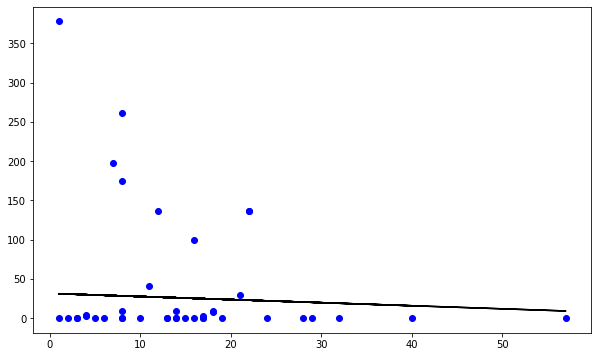

In [37]:
y_pred1 = regr1.predict(X_test1)
plt.figure(figsize=(10, 6))
plt.scatter(X_test1, y_test1, color ='b')
plt.plot(X_test1, y_pred1, color ='k')

plt.show()

**Explain the meanings of coefficients. Do they all have a meaning?**

Կոեֆիցենտն իմաստ ունի, երբ 2 փոփոխականների միջև կա որոշակի կապ, սակայն մեր տվյալներում *OVERDUEDAYS* փոփոխականը ոչ մի փոփոխականի high correlation չուներ, ինչը դժվարացրեց գծային ռեգրեսիայով բարձր կոեֆիցենտ և R2 ստանալը։

Վերևի օրինակում (Regression 1) *rcvLoansCount*-ի 1 միավորով աճելուն զուգահեռ *OVERDUEDAYS*-ը աճում է -0.925 անգամ (թիվը կարող է փոփոխվել)։ Սա հաջող ցուցանիշ չէր և ես որոշեցի մեկ այլ տարբերակով փորձել։ Այդ իսկ պատճառով ընտրեցի high correlation ունեցող 2 այլ փոփոխականներ և կատարեցի երկրորդ փորձը (ներքևում՝ Regression 2), որը հաջողվեց։

Այստեղ պարզ երևում է, որ *currentPMT*-ի աճելուն զուգահեռ, աճում է նաև *totLiab*-ը (0.63 անգամ), այսինքն ընթացիկ վարկերի ամսական վճարների գումարի աճելուն զուգահեռ աճում է նաև ընթացիկ պարտավորությունների գումարը։

## **Linear Regression 2**

In [38]:
regr_df2 = balanced_df[['currentPMT', 'totLiab']]
regr_df2.columns = ['currentPMT', 'totLiab']

fig = px.scatter(regr_df2, x="currentPMT", y="totLiab", trendline="ols")
fig.show()

In [39]:
X2 = np.array(regr_df2['currentPMT']).reshape(-1, 1)
y2 = np.array(regr_df2['totLiab']).reshape(-1, 1)
  
regr_df2.dropna(inplace = True)
  
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.25)
  
regr2 = LinearRegression()
  
regr2.fit(X_train2, y_train2)
print(regr2.score(X_test2, y_test2))
print(regr2.coef_)

0.061351405870664455
[[43.67614691]]


**Plot the response and the predictor. Display the least squares regression line.**

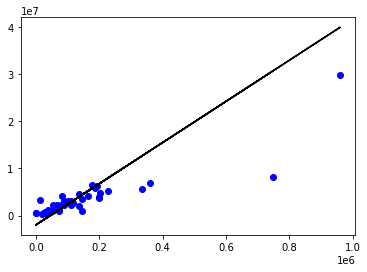

In [40]:
y_pred2 = regr2.predict(X_test2)
plt.scatter(X_test2, y_test2, color ='b')
plt.plot(X_test2, y_pred2, color ='k')

plt.show()

### **Formulate mathematically Null and Alternative hypotheses for the significance of a variable.**

***Զրոյական հիպոթեզ***՝
OVERDUEDAYS փոփոխականով հնարավոր է գծային ռեգրեսիա կատարել և բարձր R2 ստանալ։

***Ալտերնատիվ հիպոթեզ***՝
OVERDUEDAYS փոփոխականը տրված տվյալների մեջ չունի որևէ այլ փոփոխականի հետ բարձր correlation, հետևաբար հնարավոր չէ գծային ռեգրեսիայի արդյունքում բարձր R2 ստանալ:

**Are coefficients significant (for which level)? Why and why not?**

Կոեֆիցենտը նշանակալից արժեք չունի այն պարագայում, երբ 2 փոփոխականների միջև չկա գծային կապ։

Հարկ եմ համարում նշել, որ այդ 2 փոփոխականները կարող են իրար հետ խիստ կապ/առնչություն ունենալ, սակայն միևնույն ժամանակ իրենց միջև գծային կապ չլինի և հակառակը։

**Explain/Interpret the meaning of R2 in your model.**

Regression 1-ի R2-ը կազմում է -0.010419491355880606, իսկ Regression 2-ի R2-ը՝ 0.061351405870664455:

Regression 2-ի պարագայում բարձր R2-ը տրամաբանական է և համապատասխանում է իրականությանը, քանի որ ամսական վճարներին ավելանալուն զուգահեռ ավելանում են նաև ընթացիկ պարտավորությունները, հետևաբար ավելանում է նաև անձի ծախսը՝ գումարի տեսքով։

# **Task 4: Simple Logistic Regression**

## **Logistic Regression 1**
Որպես կատեգորիկ փոփոխական 'PAR1'-ի հետ ընտրեցի 'RATE'-ը, որը ցույց է տալիս վարկի տոկոսը։

In [41]:
y3 = np.array(balanced_df['PAR1']).reshape(-1, 1).ravel()
x3 = np.array(balanced_df['RATE']).reshape(-1, 1)

X_train3, X_test3, y_train3, y_test3 = train_test_split(x3, y3, test_size=0.2, random_state=42)

reg1 = LogisticRegression().fit(X_train3, y_train3)
y_pred3 = reg1.predict(X_test3)

print('Coefficient (odds):', np.exp(reg1.coef_[0]))

Coefficient (odds): [1.01202177]


Coefficient-ը հավասար է 1.01202177։

'RATE'-ի 1 միավորով աճելու դեպքում հավանականությունը, որ մեր դիտարկումները 'PAR1'- ում կլինեն 0 (Non-Overdue), 1.01202177 անգամ մեծ է, քան այն հավանականությունը, որ վերջիններս կլինեն 1 (Overdue)։

In [42]:
# 0.5-ից փոքր արժեքով տվյալները համարվում են Overdue և հակառակը
predict1 = reg1.predict(X_test3)
predict1[:11]

array([1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1])

In [43]:
# Հաջորդող output-ում կերևա 0-ի, այսինքն՝ Non-Overdue լինելու հավանականության չափը յուրաքանչյուր տեստային տվյալի համար(0-1 սանդղակով)
probac1 = reg1.predict_proba(X_test3)
probability1 = probac1[:,0]
prob_df1 = pd.DataFrame(probability1)
prob_df1.head()

,0
0,0.490488
1,0.487502
2,0.549773
3,0.508411
4,0.442642


In [44]:
# Այս աղյուսակում պարզ երևում է, թե որ պահից սկսված է տվյալը համարվում 1 (Overdue) և 0 (Non-Overdue)
prob_df1['predict'] = np.where(prob_df1[0]>=0.5, 1, 0)
prob_df1.head()

,0,predict
0,0.490488,0
1,0.487502,0
2,0.549773,1
3,0.508411,1
4,0.442642,0


In [45]:
print(classification_report(y_test3, y_pred3))

              precision    recall  f1-score   support

           0       0.64      0.53      0.58        17
           1       0.58      0.69      0.63        16

    accuracy                           0.61        33
   macro avg       0.61      0.61      0.60        33
weighted avg       0.61      0.61      0.60        33



Մոդելի ճշգրտությունը 0․61 է (61%)։ 

Classification Report-ը ցույց է տալիս, որ օգտագործված տեստային տվյալներով 'RATE'-ի 1 միավոր աճելու դեպքում 58% հավանականություն կա, որ կունենանք Overdue՝ այսինքն անձը կուշացնի ամսական վճարումը և 64% հավանականություն կա, որ կունենանք Non-Overdue՝ այսինքն անձը չի ուշացնի ամսական վճարումը։

## **Logistic Regression 2**

2-րդ Logistic Regression-ի համար 'PAR1'-ի հետ որպես կատեգորիկ փոփոխական վերցրել եմ սեռը՝ 'SEX', որը տառային արժեքից փոխել եմ թվային, որպեսզի հնարավոր լինի կատարել գործողությունը ('F'-`0`,'M'-`1`):

In [46]:
dummies = []
for i in balanced_df['SEX']:
    if i=='F':
        dummies.append(0)
    elif i =='M':
        dummies.append(1)

In [47]:
x4 = np.array(dummies).reshape(-1, 1)
y4 = balanced_df['PAR1']

X_train4, X_test4, y_train4, y_test4 = train_test_split(x4, y4, test_size=0.2, random_state=42)

reg2 = LogisticRegression().fit(X_train4, y_train4)

y_pred4 = reg2.predict(X_test4)
print('Coefficient: ', reg2.coef_)

Coefficient:  [[0.91983379]]


**Evaluate the probability of/for the base value of explanatory variable. Comment on it**

In [48]:
# Հաջորդող output-ում կերևա 0-ի, այսինքն՝ Non-Overdue լինելու և 1-ի՝ Overdue լինելու հավանականության չափը յուրաքանչյուր տեստային տվյալի համար (0-1 սանդղակով)
probac2 = reg2.predict_proba(X_test4)
prob_df2 = pd.DataFrame(probac2)
prob_df2[:6]

,0,1
0,0.396162,0.603838
1,0.396162,0.603838
2,0.622072,0.377928
3,0.396162,0.603838
4,0.622072,0.377928
5,0.396162,0.603838


In [49]:
print(classification_report(y_test4, y_pred4))

              precision    recall  f1-score   support

           0       0.50      0.47      0.48        17
           1       0.47      0.50      0.48        16

    accuracy                           0.48        33
   macro avg       0.49      0.49      0.48        33
weighted avg       0.49      0.48      0.48        33



**Calculate the exponent of the β1 coefficient. Comment on it.**

**Քայլ 1․** Նախ կգտնենք b1-ը հետևյալ բանաձևով՝ b1 = r (std y) / (std x)

**Քայլ 2․** *a × 10^b* (scientific/exponential notation formula) բանաձևով կստանանք b1-ի exponential notation-ը։


In [50]:
# Քայլ 1
r = reg2.score(X_test4, y_test4)
std_y = np.std(np.array(balanced_df['PAR1']))
std_x = np.std(dummies)

b1 = (r * std_y)/std_x
print('B1 coefficient: ', b1)

B1 coefficient:  0.4871725172661999


In [77]:
# Քայլ 2
a = b1*10 # 4.871725172661999

exp_form = a*10**-1

print("4.871725172661999*10^-1 բանաձևը b1-ի exponential ֆորման է և հավասար է", exp_form, "արժեքին։")
print(b1 == exp_form)

4.871725172661999*10^-1 բանաձևը b1-ի exponential ֆորման է և հավասար է 0.4871725172661999 արժեքին։
True
